In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv('dataset_label_3d.csv')

In [3]:
df.head()

,Stance,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z30,x31,y31,z31,x32,y32,z32,x33,y33,z33
0,Tame,0.017081,-0.615436,-0.354976,0.023743,-0.654147,-0.339717,0.024248,-0.654553,-0.339124,...,0.106091,-0.346709,0.640854,0.199478,0.749615,0.628756,-0.003005,-0.395227,0.698403,0.091981
1,Bow-Arrow,-0.086060,-0.623787,-0.128311,-0.065765,-0.661279,-0.141791,-0.065349,-0.661530,-0.141336,...,0.060965,-0.305673,0.660359,0.016075,0.517297,0.704586,-0.043896,-0.417004,0.705426,-0.066573
2,Bow-Arrow,-0.119147,-0.625371,-0.192470,-0.105032,-0.663589,-0.195877,-0.104575,-0.663897,-0.195225,...,0.076785,-0.389150,0.561384,-0.020714,0.688207,0.559055,-0.004220,-0.502432,0.624779,-0.083266
3,Bow-Arrow,0.237772,-0.644477,-0.047300,0.205139,-0.678212,-0.039447,0.205111,-0.678422,-0.038493,...,0.173230,-0.679933,0.366953,0.149973,0.549153,0.338803,0.129619,-0.653754,0.415769,0.063290
4,Bow-Arrow,-0.268363,-0.579284,-0.064051,-0.258161,-0.616762,-0.085149,-0.257637,-0.617164,-0.084190,...,-0.137475,-0.406547,0.456304,0.094538,0.814391,0.457685,-0.200070,-0.531497,0.519960,0.074109


In [4]:
# Apply stripping function to all elements in the DataFrame

df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


C:\Users\john\AppData\Local\Temp\ipykernel_14704\2516281576.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [5]:
print(df)


       Stance        x1        y1        z1        x2        y2        z2  \
0        Tame  0.017081 -0.615436 -0.354976  0.023743 -0.654147 -0.339717   
1   Bow-Arrow -0.086060 -0.623787 -0.128311 -0.065765 -0.661279 -0.141791   
2   Bow-Arrow -0.119147 -0.625371 -0.192470 -0.105032 -0.663589 -0.195877   
3   Bow-Arrow  0.237772 -0.644477 -0.047300  0.205139 -0.678212 -0.039447   
4   Bow-Arrow -0.268363 -0.579284 -0.064051 -0.258161 -0.616762 -0.085149   
..        ...       ...       ...       ...       ...       ...       ...   
56    Sitting -0.218417 -0.398879 -0.278771 -0.226623 -0.438285 -0.295347   
57    Sitting  0.316582 -0.519733 -0.129732  0.307712 -0.560967 -0.112591   
58    Sitting -0.357404 -0.526845 -0.045267 -0.350911 -0.569855 -0.066601   
59  Taijiquan  0.037122 -0.612349 -0.359622  0.047189 -0.651266 -0.342880   
60       Tame  0.028445 -0.629235 -0.339960  0.037717 -0.665901 -0.321749   

          x3        y3        z3  ...       z30       x31       y31       z

In [6]:
# Keypoints for each stance
angle_keypoints = [
    (1, 5, 8),  # Horse Stance keypoints
    (4, 5, 6),  # Bow-Arrow Stance keypoints
    (5, 9, 12),  # Sitting on Crossed Legs Stance keypoints
    (5, 21, 24),  # Four-Six Stance keypoints
    (5, 11, 14),  # Tame the Tiger Stance keypoints
    (3, 8, 12),  # False Stance keypoints
    (23, 24, 25),  # Golden Rooster Stance keypoints
    (5, 14, 17),  # Squat Stance keypoints
]

# Create a function to calculate angles based on keypoints
def calculate_angles(row, keypoints):
    angles = {}
    for i, keypoint_triplet in enumerate(keypoints):
        keypoint_1, keypoint_2, keypoint_3 = keypoint_triplet
        x1, y1, z1 = row[f'x{keypoint_1}'], row[f'y{keypoint_1}'], row[f'z{keypoint_1}']
        x2, y2, z2 = row[f'x{keypoint_2}'], row[f'y{keypoint_2}'], row[f'z{keypoint_2}']
        x3, y3, z3 = row[f'x{keypoint_3}'], row[f'y{keypoint_3}'], row[f'z{keypoint_3}']

        ba = np.array([x1 - x2, y1 - y2, z1 - z2])
        bc = np.array([x3 - x2, y3 - y2, z3 - z2])

        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = math.degrees(np.arccos(cosine_angle))

        if angle > 180.0:
            angle = 360 - angle
        
        stance_name = f'Stance {i + 1}'
        angles[stance_name] = angle
    
    return angles


In [7]:
# Calculate angles for each row in the dataset based on the angle_keypoints
angle_features = df.apply(calculate_angles, args=(angle_keypoints,), axis=1)

# Convert the angle_features (Series) to a DataFrame
angle_features_df = pd.DataFrame(angle_features.tolist())

# Rename the columns to make them more meaningful (e.g., Angle_1, Angle_2, ...)
angle_features_df.columns = [f'Angle_{i+1}' for i in range(angle_features_df.shape[1])]

# Concatenate the angle features with your original dataset
df = pd.concat([df, angle_features_df], axis=1)


In [8]:
df

,Stance,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,y33,z33,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5,Angle_6,Angle_7,Angle_8
0,Tame,0.017081,-0.615436,-0.354976,0.023743,-0.654147,-0.339717,0.024248,-0.654553,-0.339124,...,0.698403,0.091981,82.707126,72.408218,81.960241,83.019647,150.295402,124.565915,34.397046,74.322061
1,Bow-Arrow,-0.086060,-0.623787,-0.128311,-0.065765,-0.661279,-0.141791,-0.065349,-0.661530,-0.141336,...,0.705426,-0.066573,92.621954,42.317220,86.439816,103.247575,142.285736,124.207511,29.765276,75.647379
2,Bow-Arrow,-0.119147,-0.625371,-0.192470,-0.105032,-0.663589,-0.195877,-0.104575,-0.663897,-0.195225,...,0.624779,-0.083266,81.512089,41.212651,74.258496,94.192567,148.828433,110.173873,24.151011,81.569812
3,Bow-Arrow,0.237772,-0.644477,-0.047300,0.205139,-0.678212,-0.039447,0.205111,-0.678422,-0.038493,...,0.415769,0.063290,95.467362,121.190815,80.509514,52.100395,147.154740,117.705861,99.390331,38.602086
4,Bow-Arrow,-0.268363,-0.579284,-0.064051,-0.258161,-0.616762,-0.085149,-0.257637,-0.617164,-0.084190,...,0.519960,0.074109,90.500958,47.012815,84.180066,88.206790,147.020091,126.156469,19.846969,88.029119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Sitting,-0.218417,-0.398879,-0.278771,-0.226623,-0.438285,-0.295347,-0.226295,-0.438411,-0.294299,...,0.234613,-0.178670,76.435666,35.770438,96.573721,43.670204,136.719215,132.613598,26.571928,52.511310
57,Sitting,0.316582,-0.519733,-0.129732,0.307712,-0.560967,-0.112591,0.308066,-0.561479,-0.111612,...,0.271073,-0.073487,95.582363,107.785526,67.731928,87.996182,106.292622,102.757621,30.679485,50.072236
58,Sitting,-0.357404,-0.526845,-0.045267,-0.350911,-0.569855,-0.066601,-0.350643,-0.569925,-0.065803,...,0.420652,0.243162,91.747385,47.440659,97.893534,52.190621,133.752036,131.598795,59.274166,30.816142
59,Taijiquan,0.037122,-0.612349,-0.359622,0.047189,-0.651266,-0.342880,0.047540,-0.651710,-0.342385,...,0.796968,0.010351,86.005879,78.292916,83.036394,70.761568,157.612865,124.938059,39.239125,92.010316


In [9]:
# Save the dataset to a CSV file
df.to_csv('taijiquan_dataset.csv', index = False)

In [10]:
dataset = pd.read_csv('taijiquan_dataset.csv')

In [11]:
dataset

,Stance,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,y33,z33,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5,Angle_6,Angle_7,Angle_8
0,Tame,0.017081,-0.615436,-0.354976,0.023743,-0.654147,-0.339717,0.024248,-0.654553,-0.339124,...,0.698403,0.091981,82.707126,72.408218,81.960241,83.019647,150.295402,124.565915,34.397046,74.322061
1,Bow-Arrow,-0.086060,-0.623787,-0.128311,-0.065765,-0.661279,-0.141791,-0.065349,-0.661530,-0.141336,...,0.705426,-0.066573,92.621954,42.317220,86.439816,103.247575,142.285736,124.207511,29.765276,75.647379
2,Bow-Arrow,-0.119147,-0.625371,-0.192470,-0.105032,-0.663589,-0.195877,-0.104575,-0.663897,-0.195225,...,0.624779,-0.083266,81.512089,41.212651,74.258496,94.192567,148.828433,110.173873,24.151011,81.569812
3,Bow-Arrow,0.237772,-0.644477,-0.047300,0.205139,-0.678212,-0.039447,0.205111,-0.678422,-0.038493,...,0.415769,0.063290,95.467362,121.190815,80.509514,52.100395,147.154740,117.705861,99.390331,38.602086
4,Bow-Arrow,-0.268363,-0.579284,-0.064051,-0.258161,-0.616762,-0.085149,-0.257637,-0.617164,-0.084190,...,0.519960,0.074109,90.500958,47.012815,84.180066,88.206790,147.020091,126.156469,19.846969,88.029119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Sitting,-0.218417,-0.398879,-0.278771,-0.226623,-0.438285,-0.295347,-0.226295,-0.438411,-0.294299,...,0.234613,-0.178670,76.435666,35.770438,96.573721,43.670204,136.719215,132.613598,26.571928,52.511310
57,Sitting,0.316582,-0.519733,-0.129732,0.307712,-0.560967,-0.112591,0.308066,-0.561479,-0.111612,...,0.271073,-0.073487,95.582363,107.785526,67.731928,87.996182,106.292622,102.757621,30.679485,50.072236
58,Sitting,-0.357404,-0.526845,-0.045267,-0.350911,-0.569855,-0.066601,-0.350643,-0.569925,-0.065803,...,0.420652,0.243162,91.747385,47.440659,97.893534,52.190621,133.752036,131.598795,59.274166,30.816142
59,Taijiquan,0.037122,-0.612349,-0.359622,0.047189,-0.651266,-0.342880,0.047540,-0.651710,-0.342385,...,0.796968,0.010351,86.005879,78.292916,83.036394,70.761568,157.612865,124.938059,39.239125,92.010316


In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Define the columns you want to scale, including your x, y, z coordinates, and angle columns
columns_to_scale = [
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
    'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33',
    'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20',
    'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28', 'y29', 'y30', 'y31', 'y32', 'y33',
    'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16', 'z17', 'z18', 'z19', 'z20',
    'z21', 'z22', 'z23', 'z24', 'z25', 'z26', 'z27', 'z28', 'z29', 'z30', 'z31', 'z32', 'z33',
    'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5', 'Angle_6', 'Angle_7', 'Angle_8'
]

# Fit and transform the selected columns using the scaler
dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])


In [13]:
X = dataset.drop(columns=['Stance'])  # Features (excluding the labels)
y = dataset['Stance']  # Stance labels


In [14]:
# Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Train the SVM Model
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=100)  # Adjust kernel and C as needed
svm_model.fit(X_train, y_train)


SVC(C=100, kernel='linear')

In [16]:
# Make Predictions
y_pred = svm_model.predict(X_test)

MCC: 0.58
Confusion Matrix:
[[1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 7 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]]


c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Classification Report:
                precision    recall  f1-score   support

     Bow-Arrow       0.25      1.00      0.40         1
      Four-Six       0.00      0.00      0.00         1
Golden Rooster       0.00      0.00      0.00         1
         Horse       1.00      1.00      1.00         7
       Sitting       0.00      0.00      0.00         1
     Taijiquan       0.00      0.00      0.00         1
          Tame       0.50      1.00      0.67         1

      accuracy                           0.69        13
     macro avg       0.25      0.43      0.30        13
  weighted avg       0.60      0.69      0.62        13



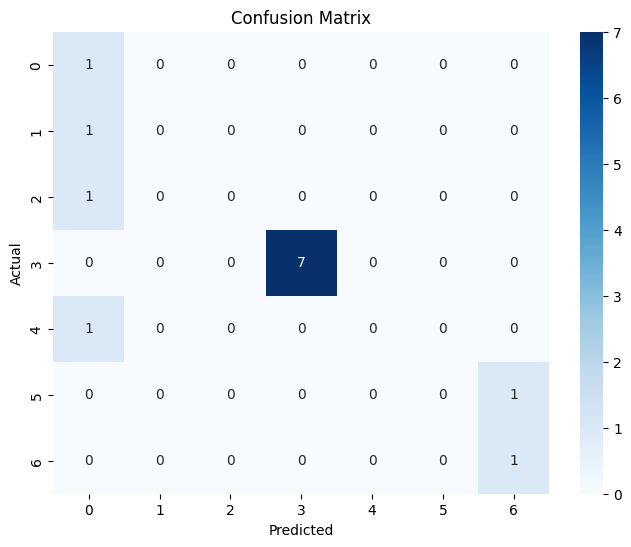

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc:.2f}")

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

# For more detailed classification metrics:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Define Hyperparameters to Tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
}


In [19]:
# Prepare the Hyperparameter Grid
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Create an SVM classifier
svm = SVC()

# Split Data for Cross-Validation
# Ensure you have X_train, y_train

# Step 4: Perform Grid Search with Cross-Validation (Include Validation)
grid_search = GridSearchCV(svm, param_grid, cv=5)  # You can adjust the number of folds

# Fit the grid search to your data
grid_search.fit(X_train, y_train)


c:\Users\john\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']})

In [20]:
# Evaluate the Best Model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on your test data (no separate validation set)
accuracy = best_model.score(X_test, y_test)
print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy)


Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Test Accuracy: 0.6923076923076923


In [21]:
import joblib

joblib.dump(svm_model, 'svm_model.pkl')


['svm_model.pkl']

In [22]:
# Display the number of features (columns) in your DataFrame
num_features = len(df.columns)
print(f"Number of features: {num_features}")

Number of features: 108


In [23]:
X_test.columns

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4',
       ...
       'y33', 'z33', 'Angle_1', 'Angle_2', 'Angle_3', 'Angle_4', 'Angle_5',
       'Angle_6', 'Angle_7', 'Angle_8'],
      dtype='object', length=107)